# Grid size vs distribution:

**is log log slope the same?**
**How does the exp cut-off change?**

In [6]:
import os 
directory_changed = False 
try:
    from simulations.drosselschwab import simulate_drosselschwab
except:
    print("Adjusting path for imports..")
    os.chdir("..")
    directory_changed = True
    from simulations.drosselschwab import simulate_drosselschwab

import results
import data
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import csv
from pathlib import Path
from datetime import datetime
print(os.getcwd())
from scriptss.parallel_sims import worker
import numpy as np


c:\Users\rorka\PycharmProjects\AIHealth\CSS_project-19


In [ ]:
# # Then when saving a file you can use the path function like so:
# results_path = results.path('p_param_2.csv')
# data_path = data.path('p_param_2.csv')
# print(results_path, data_path)

Run code below to make each time a new dir in figuresRohan. Needed for all the experiments

In [8]:
if directory_changed:
    base_dir = Path("data/figuresRohan").resolve()
else:
    base_dir = Path("../data/figuresRohan").resolve()
    
base_dir.mkdir(parents=True, exist_ok=True)
idx = 1
while (base_dir / f"experiment_{idx}").exists():
    idx += 1
outdir = base_dir / f"experiment_{idx}"
outdir.mkdir(parents=True, exist_ok=False)
print(f"Saving notebook run results to experiment directory: {outdir}")

Saving notebook run results to experiment directory: C:\Users\rorka\PycharmProjects\AIHealth\data\figuresRohan\experiment_2


In [9]:
# Example parameter sweep: small demo grid. Replace with your actual sweep.
param_list = []
param_idx = 1
L = 256
steps = 100

runs_per_param = 1

f_over_p_ratios = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

p_values = [0.1]
f_values = [p_values[0]*f_over_p_ratio for f_over_p_ratio in f_over_p_ratios]

for p in p_values:
    for f in f_values:

        for run_idx in range(runs_per_param):
            param_list.append({'L': L, 'p': p, 'f': f, 'steps': steps, 'param_id': param_idx, 'run_id': run_idx})
        param_idx += 1

In [10]:
max_workers = int(os.environ.get('MAX_WORKERS', multiprocessing.cpu_count()))
print(f"Running {len(param_list)} simulations with up to {max_workers} workers...")

results = []
with ProcessPoolExecutor(max_workers=max_workers) as exe:
    # pass outdir as first argument to worker
    futures = {exe.submit(worker, outdir, params): params for params in param_list}
    for fut in as_completed(futures):
        params = futures[fut]
        try:
            res = fut.result()
            print(f"Done: p={res['p']}, f={res['f']}, fires={res['num_fires']}, mean={res['mean_size']:.2f}, max={res['max_size']}")
            results.append(res)
        except Exception as e:
            print(f"Error for params {params}: {e}")

# Write a summary CSV
summary_file = outdir / f"summary_{datetime.now().strftime('%Y%m%dT%H%M%SZ')}.csv"
keys = ['L', 'p', 'f', 'steps', 'param_id', 'run_id', 'num_fires', 'mean_size', 'max_size', 'remaining_trees', 'raw_file']
with open(summary_file, 'w', newline='') as fh:
    writer = csv.DictWriter(fh, keys)
    writer.writeheader()
    for r in results:
        writer.writerow({k: r.get(k, '') for k in keys})

print(f"Summary written to {summary_file}")


Running 7 simulations with up to 8 workers...
Done: p=0.1, f=0.1, fires=140225, mean=3.82, max=48
Done: p=0.1, f=0.05, fires=82733, mean=6.10, max=83
Done: p=0.1, f=0.010000000000000002, fires=20935, mean=21.44, max=474
Done: p=0.1, f=0.0001, fires=273, mean=1436.58, max=29806
Done: p=0.1, f=0.005000000000000001, fires=11221, mean=38.58, max=749
Done: p=0.1, f=0.001, fires=2468, mean=165.10, max=4476
Done: p=0.1, f=0.0005, fires=1229, mean=325.90, max=14398
Summary written to C:\Users\rorka\PycharmProjects\AIHealth\data\figuresRohan\experiment_2\summary_20260123T140034Z.csv


In [11]:
# --- New analysis cells: load per-step CSVs from the latest experiment and compute statistics ---
import json
import csv
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# auto-detect latest experiment directory under data/figuresRohan
if not base_dir.exists():
    raise FileNotFoundError(f"Base data directory not found: {base_dir}")
exp_dirs = [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith('experiment_')]
if not exp_dirs:
    raise FileNotFoundError(f"No experiment directories found under {base_dir}")
def _exp_index(d):
    try:
        return int(d.name.split('_')[-1])
    except Exception:
        return -1
exp_dirs_sorted = sorted(exp_dirs, key=_exp_index)
EXP_DIR = exp_dirs_sorted[-1].resolve()
print('Experiment dir:', EXP_DIR)

# find perstep files created by the worker
perstep_files = sorted(EXP_DIR.glob('perstep_param*_*.csv'))
print(f'Found {len(perstep_files)} per-step files')

# filename pattern to extract param_id and run_id
pattern = re.compile(r'perstep_param(?P<param>\d+)_.*_id(?P<run>\d+)_')


def load_perstep_file(fp):
    records = []
    with open(fp, newline='') as fh:
        reader = csv.reader(fh)
        try:
            header = next(reader)
        except StopIteration:
            return records
        for row in reader:
            if not row:
                continue
            # expected columns: step, fire_size (JSON), cluster distr (JSON), mean tree density
            step = int(row[0])
            fires = json.loads(row[1]) if row[1] else []
            clusters = json.loads(row[2]) if row[2] else []
            density = float(row[3]) if row[3] != '' else None
            records.append({'step': step, 'fires': fires, 'clusters': clusters, 'density': density})
    return records

# organize runs by param_id
runs_by_param = {}  # param_id -> list of runs
for fp in perstep_files:
    m = pattern.search(fp.name)
    if not m:
        print('Skipping unknown file pattern:', fp.name)
        continue
    pid = int(m.group('param'))
    rid = int(m.group('run'))
    recs = load_perstep_file(fp)
    # aggregate series for convenience
    fires_all = []
    clusters_all = []
    density_series = []
    for r in recs:
        fires_all.extend(r['fires'])
        clusters_all.extend(r['clusters'])
        density_series.append(r['density'])
    runs_by_param.setdefault(pid, []).append({'run_id': rid, 'file': fp, 'records': recs, 'fires_all': fires_all, 'clusters_all': clusters_all, 'density_series': density_series})

print('Loaded runs for param_ids:', sorted(runs_by_param.keys()))


Experiment dir: C:\Users\rorka\PycharmProjects\AIHealth\data\figuresRohan\experiment_2
Found 7 per-step files
Loaded runs for param_ids: [1, 2, 3, 4, 5, 6, 7]


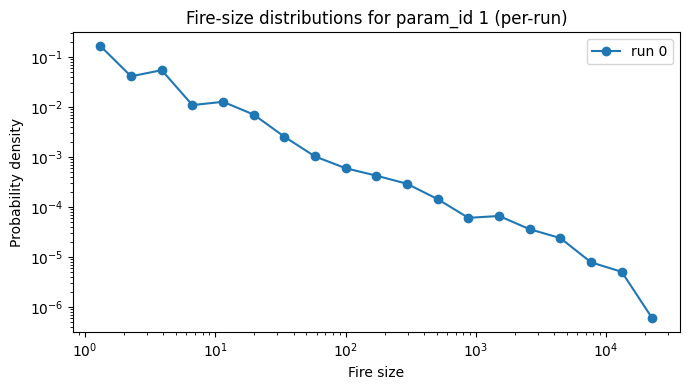

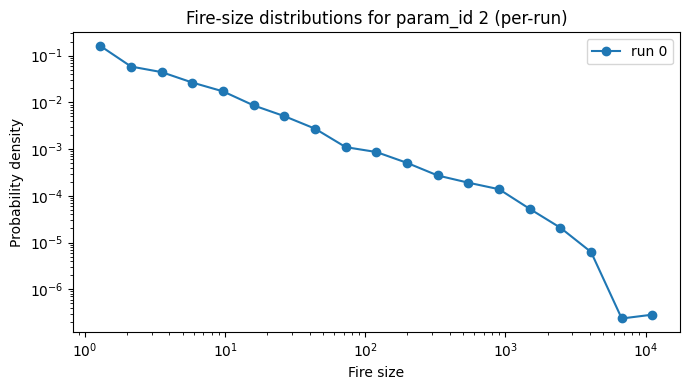

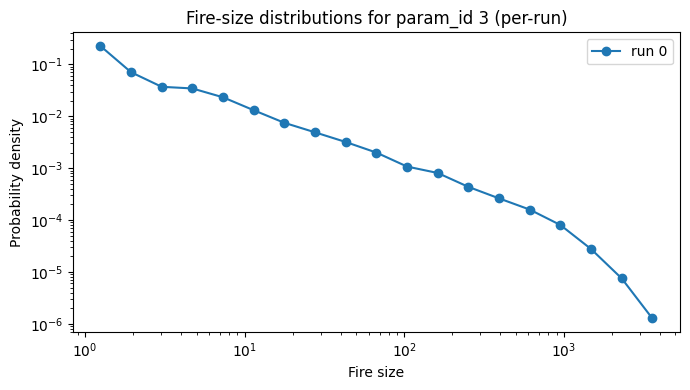

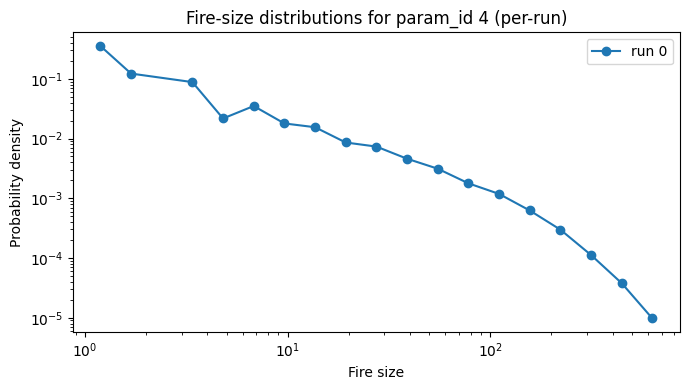

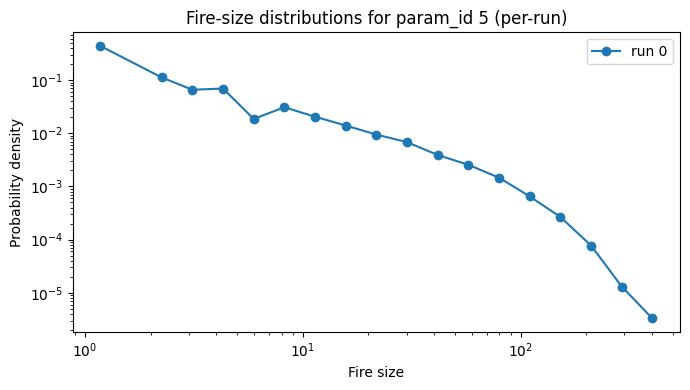

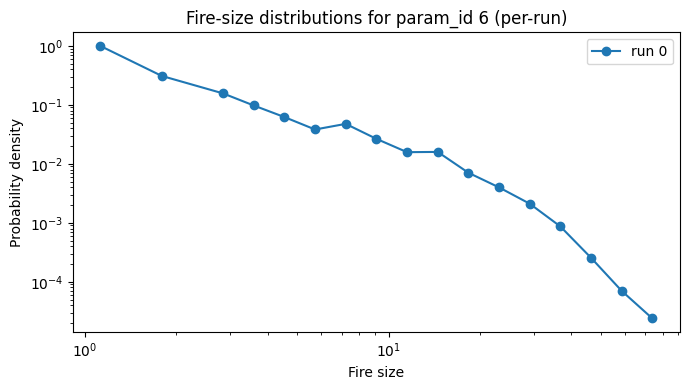

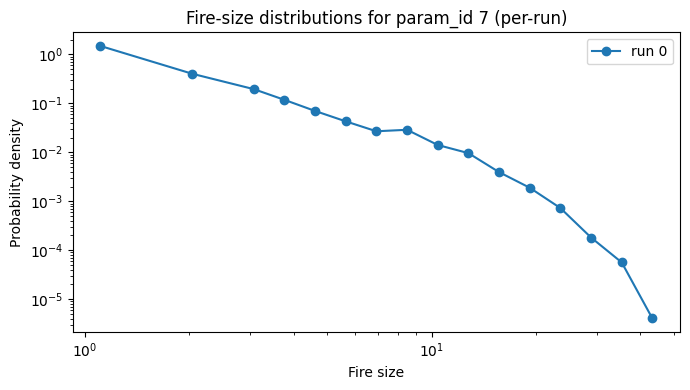

In [12]:
# Plot: Fire-size distributions for individual runs with the same param_id
# Choose a param_id to inspect (if multiple present, this will loop over all)
for pid in sorted(runs_by_param.keys()):
    runs = runs_by_param[pid]
    if not runs:
        continue
    plt.figure(figsize=(7, 4))
    # compute global min/max across runs for consistent bins
    all_fs = np.concatenate([np.array(r['fires_all']) for r in runs if len(r['fires_all']) > 0]) if any(len(r['fires_all'])>0 for r in runs) else np.array([])
    if all_fs.size == 0:
        print(f'param_id {pid}: no fires recorded in any run')
        continue
    min_s = max(1, int(all_fs.min()))
    max_s = int(all_fs.max())
    bins = np.logspace(np.log10(min_s), np.log10(max_s), num=20)

    for r in runs:
        fs = np.array(r['fires_all'])
        if fs.size == 0:
            continue
        hist, edges = np.histogram(fs, bins=bins, density=True)
        centers = np.sqrt(edges[:-1] * edges[1:])
        mask = hist > 0
        plt.loglog(centers[mask], hist[mask], marker='o', linestyle='-', label=f"run {r['run_id']}")

    plt.title(f'Fire-size distributions for param_id {pid} (per-run)')
    plt.xlabel('Fire size')
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()
    plt.show()


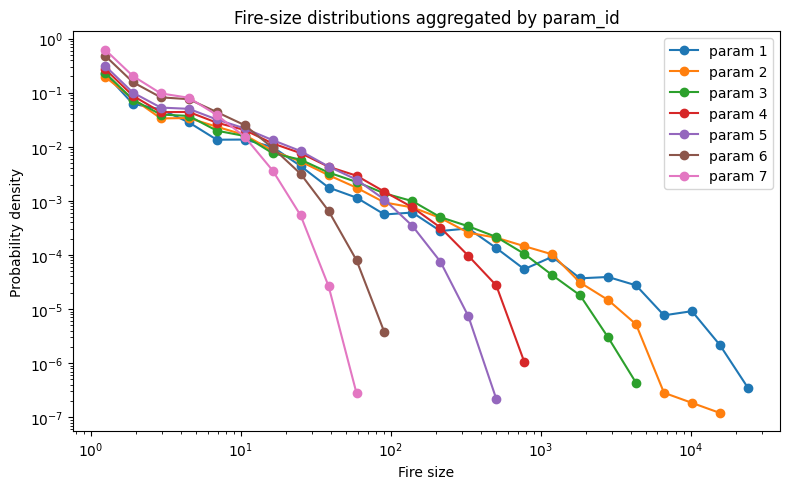

In [13]:
# Plot: Fire-size distributions aggregated across runs for different param_ids
# compute global bins across all param_ids
all_fires_global = np.concatenate([np.concatenate([np.array(r['fires_all']) for r in runs_by_param[pid] if len(r['fires_all'])>0]) for pid in runs_by_param.keys() if any(len(r['fires_all'])>0 for r in runs_by_param[pid])]) if any(any(len(r['fires_all'])>0 for r in runs_by_param[pid]) for pid in runs_by_param.keys()) else np.array([])
if all_fires_global.size > 0:
    min_s = max(1, int(all_fires_global.min()))
    max_s = int(all_fires_global.max())
    bins = np.logspace(np.log10(min_s), np.log10(max_s), num=25)

    plt.figure(figsize=(8, 5))
    for pid in sorted(runs_by_param.keys()):
        runs = runs_by_param[pid]
        # aggregate fires across runs for this param_id
        agg = np.concatenate([np.array(r['fires_all']) for r in runs if len(r['fires_all']) > 0]) if any(len(r['fires_all'])>0 for r in runs) else np.array([])
        if agg.size == 0:
            continue
        hist, edges = np.histogram(agg, bins=bins, density=True)
        centers = np.sqrt(edges[:-1] * edges[1:])
        mask = hist > 0
        plt.loglog(centers[mask], hist[mask], marker='o', linestyle='-', label=f'param {pid}')

    plt.title('Fire-size distributions aggregated by param_id')
    plt.xlabel('Fire size')
    plt.ylabel('Probability density')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No fires in any run to plot aggregated distributions')


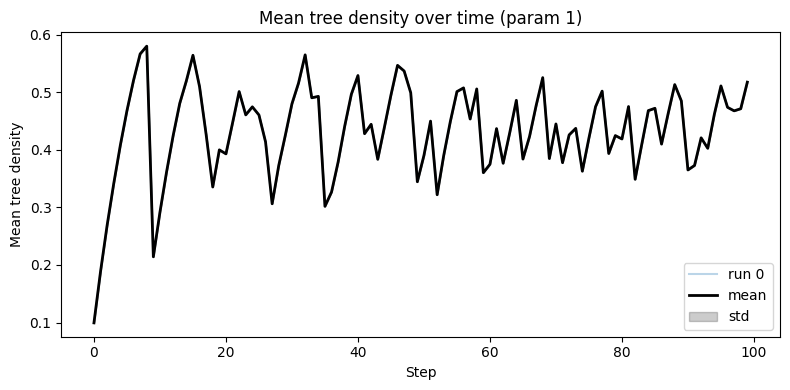

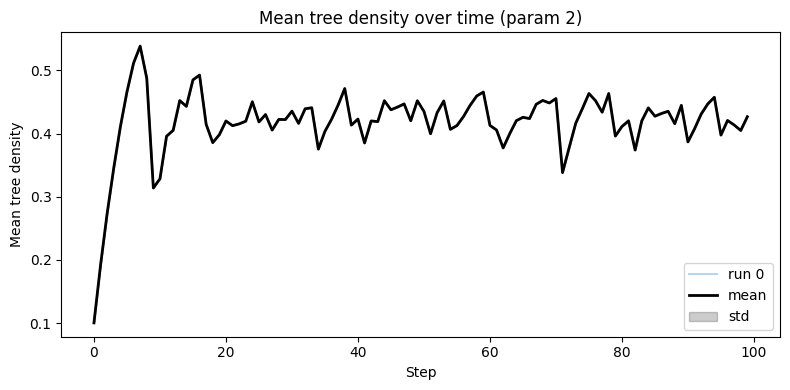

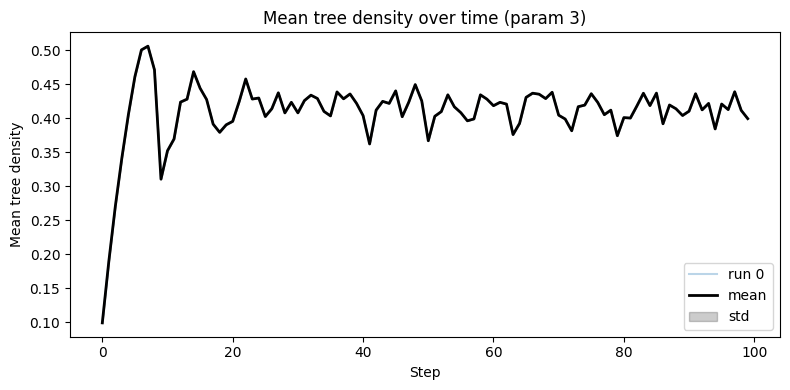

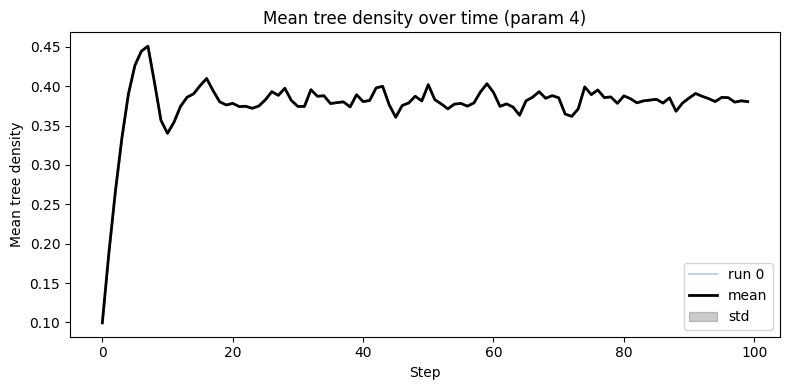

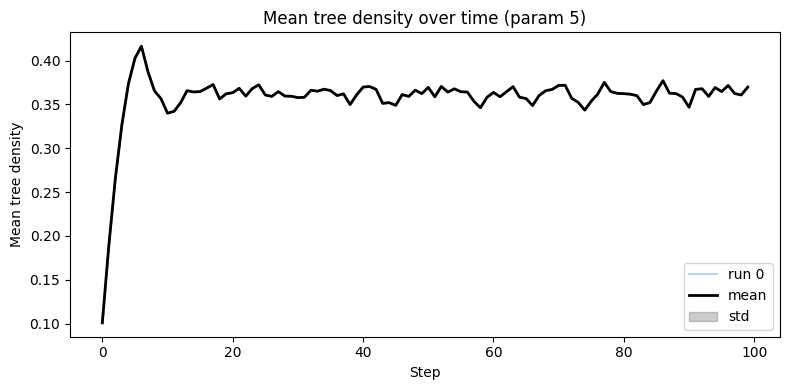

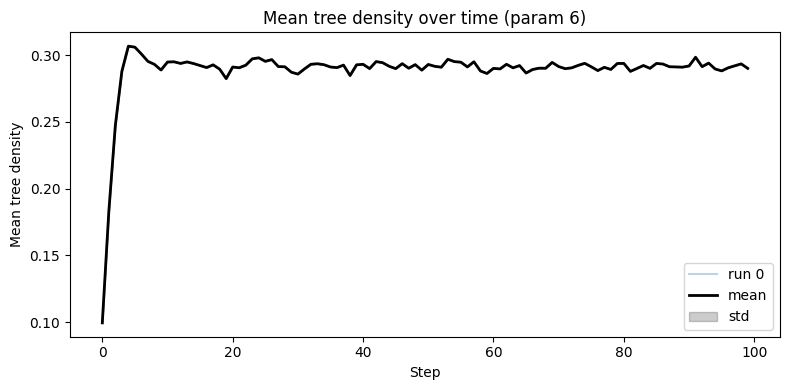

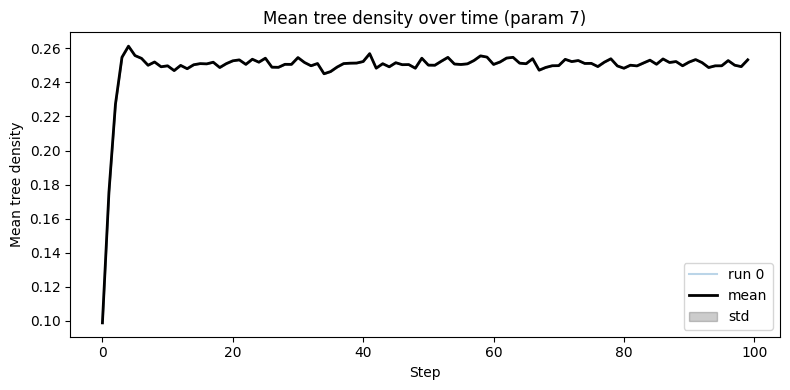

In [14]:
# Plot: Mean tree density time series per run and averaged per param_id
for pid in sorted(runs_by_param.keys()):
    runs = runs_by_param[pid]
    if not runs:
        continue
    plt.figure(figsize=(8, 4))
    # collect arrays of densities; pad shorter runs if needed
    densities = [np.array(r['density_series'], dtype=float) for r in runs if len(r['density_series'])>0]
    if not densities:
        print(f'param {pid}: no density series available')
        continue
    maxlen = max(arr.size for arr in densities)
    stacked = np.vstack([np.pad(arr, (0, maxlen - arr.size), constant_values=np.nan) for arr in densities])
    # plot individual runs
    for i, arr in enumerate(stacked):
        plt.plot(np.arange(arr.size), arr, alpha=0.3, label=f'run {runs[i]["run_id"]}')
    # mean and std across runs (ignore nan)
    mean_series = np.nanmean(stacked, axis=0)
    std_series = np.nanstd(stacked, axis=0)
    x = np.arange(mean_series.size)
    plt.plot(x, mean_series, color='k', linewidth=2, label='mean')
    plt.fill_between(x, mean_series - std_series, mean_series + std_series, color='k', alpha=0.2, label='std')
    plt.title(f'Mean tree density over time (param {pid})')
    plt.xlabel('Step')
    plt.ylabel('Mean tree density')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# L = 256
# p = 0.01
# f = 0.0001
# steps = 10000

# print("Start experiment:")

# fire_sizes, grid = simulate_drosselschwab(L=L, p=p, f=f, steps=steps)

Start experiment:
